In [1]:
import torch
from fastai.vision.all import *

from fastcore.xtras import Path

from fastai.callback.hook import summary
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_flat_cos

from fastai.data.block import DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize

from fastai.layers import Mish
from fastai.losses import BaseLoss
from fastai.optimizer import ranger

from fastai.torch_core import tensor

from fastai.vision.augment import aug_transforms
from fastai.vision.core import PILImage, PILMask
from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats
from fastai.vision.learner import unet_learner

from PIL import Image
import numpy as np

from torch import nn
from torchvision.models.resnet import resnet18, resnet34, resnet50, resnet152

import torch
import torch.nn.functional as F
import gc
import time
import pandas as pd

In [2]:
import torch
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
else:
    print('The GPU is not used.')

NVIDIA GeForce RTX 3090


# Set the paths

In [3]:
path = '//rcs920/Experiments/2022/OPERA/Segmentation/Copper-train-valid-test/'


path_im = path + 'Segmentation-Copper'
#res_img_path = path + 'classified samples/'
label_folder = 'Copper-labels'
path_lbl = path + label_folder
vfn = path + 'copper-valid.txt'

In [19]:

x = torch.randn(20, 5) #The input is expected to contain raw, unnormalized scores for each class.
 
y = torch.randint(0, 5, (20,))
 
print(Counter(y.numpy()))

Counter({3: 7, 2: 4, 4: 4, 0: 3, 1: 2})


In [20]:
y

tensor([2, 3, 3, 3, 1, 3, 0, 2, 3, 3, 4, 3, 4, 2, 0, 4, 2, 0, 4, 1])

In [21]:
y1 = [4, 0, 0, 2, 4, 0, 4, 3, 2, 0, 4, 0, 0, 1, 0, 1, 1, 1, 2, 1]
np.asarray(y1)

array([4, 0, 0, 2, 4, 0, 4, 3, 2, 0, 4, 0, 0, 1, 0, 1, 1, 1, 2, 1])

In [22]:
np.unique(y)

array([0, 1, 2, 3, 4], dtype=int64)

In [23]:
from sklearn.utils.class_weight import compute_class_weight

class_weights=compute_class_weight(class_weight = 'balanced', classes = np.unique(y), y = y.numpy())
class_weights=torch.tensor(class_weights,dtype=torch.float)
 
print(class_weights)

tensor([1.3333, 2.0000, 1.0000, 0.5714, 1.0000])


In [24]:
np.bincount(y)
#n_samples / (n_classes * np.bincount(y))
len(y) / (len(np.unique(y)) * 3)

1.3333333333333333

In [25]:
weights = torch.tensor([0.1, 1.9, 1.9, 1.9, 1.9]).cuda()
weights

tensor([0.1000, 1.9000, 1.9000, 1.9000, 1.9000], device='cuda:0')

# Compute the weights for each training-validation spit in turn and save them to a csv file

In [26]:
import pandas as pd

def get_occurrences_pixels_per_class(flatten_list, what_classes):
    existing_for_df = []
    for i in range(len(codes)):
        if i in what_classes:
            existing_for_df.append(list(flatten_list).count(i))
        else:
            existing_for_df.append(0)
    return existing_for_df

def get_msk(img_fn):
    str_fn = str(img_fn)
    just_msk_fn = str_fn.split('\\')[-1][:-4] + '_P.png'
    folder = str_fn.rpartition('Segmentation-Copper\\')[0] + label_folder + '/'
    return Path(folder + just_msk_fn)

def FileSplitter(fname):
    "Split `items` depending on the value of `mask`."
    with open(vfn) as f:
        valid = [line.rstrip() for line in f]
    def _func(x): return x.name in valid
    def _inner(o, **kwargs): return FuncSplitter(_func)(o)
    return _inner


def compute_weights_for_validaion_no():
    
    print('vfn = ', vfn)
    opera = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                        get_items=get_image_files,
                        splitter=FileSplitter(vfn),
                        get_y=get_msk,
                        batch_tfms=[*aug_transforms(size=half), Normalize.from_stats(*imagenet_stats)])

    dls = opera.dataloaders(path + 'Segmentation-Copper', bs=bs, num_workers = 0)
    print('No of items in the training set: ', len(dls.train_ds.items))
    name2id = {v:k for k,v in enumerate(codes)}
    existing_classes = np.array([0, 1, 2, 3, 4], dtype='uint8')
    all_occurrences = []
    k = 0
    for training_fn in dls.train_ds.items:
        msk = PILMask.create(get_msk(training_fn))
        trg = np.asarray(msk)
        pix_per_class = get_occurrences_pixels_per_class(trg.flatten(), existing_classes)
        if k < 3:
            print('training_fn = {}, pix_per_class = {}'.format(training_fn, pix_per_class))
        all_occurrences.append(pix_per_class)
        k += 1 
    sum_pixels_per_class = [sum(i) for i in zip(*all_occurrences)]
    print('sum_pixels_per_class = ', sum_pixels_per_class)
    total_pixels = sum(sum(x) for x in all_occurrences)
    print('total_pixels = ', total_pixels)
    weights = []
    for i in range(len(existing_classes)):
        weights.append(total_pixels / (len(existing_classes) * sum_pixels_per_class[i]))
    return weights

fnames = get_image_files(path_im)
lbl_names = get_image_files(path_lbl)
codes = np.loadtxt(path + 'copper-codes.txt', dtype=str)
#check one image
img_fn = fnames[15]

msk = PILMask.create(get_msk(img_fn))

bs = 4
sz = msk.shape
half = tuple(int(x/4) for x in sz)
all_weights = []
list_columns = ['Split', '$Cu$', 'clorura-$CuCl$', 'hidroxocarbonat - $(CuOH)_{2}C0_3$ ', 'oxid cupric - $CuO$', 'oxid cupros - $Cu_2O$']
val_no = 1
vfn = path + 'copper-valid.txt'
weights = compute_weights_for_validaion_no()
weights.insert(0, val_no)
all_weights.append(weights)
df = pd.DataFrame(all_weights)
df.to_csv(path + 'copper-weights.csv', index=False, header=list_columns)

vfn =  //rcs920/Experiments/2022/OPERA/Segmentation/Copper-train-valid-test/copper-valid.txt
No of items in the training set:  131


KeyboardInterrupt: 

In [ ]:
df

,0,1,2,3,4,5
0,1,0.212137,24.205526,8.902328,14.270371,16.036754


In [ ]:
list_columns = ['Split', '$Cu$', 'clorura-$CuCl$', 'hidroxocarbonat - $(CuOH)_{2}C0_3$ ', 'oxid cupric - $CuO$', 'oxid cupros - $Cu_2O$']
weights2 = weights.copy()

In [ ]:
all_weights = []
all_weights.append(weights2)
#weights2.insert(0, 1)
weights

[1,
 0.21213744690481245,
 24.205526108041052,
 8.90232805316376,
 14.270371440028756,
 16.03675378318238]

In [ ]:
import pandas as pd

df = pd.DataFrame(all_weights)
df.to_csv(path + 'copper-weights.csv', index=False, header=list_columns)

In [ ]:
df1 = pd.read_csv(path + 'copper-weights.csv')
df1

,Split,$Cu$,clorura-$CuCl$,hidroxocarbonat - $(CuOH)_{2}C0_3$,oxid cupric - $CuO$,oxid cupros - $Cu_2O$
0,1,0.212137,24.205526,8.902328,14.270371,16.036754


# Find for one file the occurrences for its classes

In [ ]:
def get_occurrences_pixels_per_class(flatten_list, what_classes):
    existing_for_df = []
    for i in range(len(codes)):
        if i in what_classes:
            existing_for_df.append(list(flatten_list).count(i))
        else:
            existing_for_df.append(0)
    return existing_for_df

def compute_weights():
    existing_classes = np.array([0, 1, 2, 3, 4], dtype='uint8')
    all_occurrences = []
    for training_fn in dls.train_ds.items:
        msk = PILMask.create(get_msk(training_fn))
        trg = np.asarray(msk)
        
        all_occurrences.append(get_occurrences_pixels_per_class(trg.flatten(), existing_classes)) 
    sum_pixels_per_class = [sum(i) for i in zip(*all_occurrences)]
    total_pixels = sum(sum(x) for x in all_occurrences)
    weights = []
    for i in range(len(existing_classes)):
        weights.append(total_pixels / (len(existing_classes) * sum_pixels_per_class[i]))
    return weights
#find existing classes first
#msk = PILMask.create(get_msk(dls.train_ds.items[0]))
#existing_classes = np.unique(trg.flatten())

existing_classes = np.array([0, 1, 2, 3, 4], dtype='uint8')

all_occurrences = []

for training_fn in dls.train_ds.items:
    msk = PILMask.create(get_msk(training_fn))
    trg = np.asarray(msk)
    
    all_occurrences.append(get_occurrences_pixels_per_class(trg.flatten(), existing_classes))


In [ ]:
sum_pixels_per_class = [sum(i) for i in zip(*all_occurrences)]
total_pixels = sum(sum(x) for x in all_occurrences)

In [ ]:
weights = []
for i in range(len(existing_classes)):
    weights.append(total_pixels / (len(existing_classes) * sum_pixels_per_class[i]))
weights

[0.21144121609756256,
 29.070039897517354,
 9.606249820205257,
 16.016377707333486,
 14.364007266205856]

In [ ]:
existing_classes

array([0, 1, 2, 3, 4], dtype=uint8)

In [ ]:
np.unique(trg.flatten())

array([0, 1, 2, 3, 4], dtype=uint8)

In [ ]:
len(dls.train_ds)

138

In [30]:
def get_weigths_for_val_no(val_no):
    df = pd.read_csv(path + 'copper-weights.csv')
    class_weights = df.loc[df.Split == val_no].values.flatten().tolist()[1:]
    return torch.tensor(class_weights, dtype=torch.float)
get_weigths_for_val_no(2)

tensor([7.3988, 7.4184, 4.0351, 7.1313, 9.7510])

# Run the models using the computed weights

sz =  (768, 1024)
half =  (192, 256)
Startin val_no: 3
vfn =  //rcs920/Experiments/2022/OPERA/Segmentation/Copper-train-valid-test/copper-valid.txt
Finding the lrs.
Start training


epoch,train_loss,valid_loss,acc_opera,time
0,0.749006,0.289118,0.955722,00:21
1,0.462571,0.206918,0.955918,00:20
2,0.359064,0.171448,0.955909,00:20
3,0.298559,0.160442,0.955921,00:20
4,0.269971,0.146694,0.955853,00:19
5,0.245559,0.136405,0.956220,00:19
6,0.235404,0.182124,0.950458,00:20
7,0.224447,0.137111,0.956796,00:21
8,0.210250,0.131986,0.957264,00:21
9,0.194631,0.129941,0.957431,00:20


Validating


epoch,train_loss,valid_loss,acc_opera,time
0,0.176188,0.131125,0.957514,00:23
1,0.177660,0.130999,0.956991,00:21
2,0.175072,0.130425,0.957541,00:21
3,0.171411,0.133797,0.957557,00:20
4,0.170335,0.136209,0.955746,00:21
5,0.167463,0.136344,0.955758,00:23
6,0.166087,0.134696,0.954572,00:24
7,0.165317,0.132751,0.958087,00:20
8,0.162292,0.133043,0.956236,00:20
9,0.157903,0.131385,0.957888,00:20


Startin val_no: 4
vfn =  //rcs920/Experiments/2022/OPERA/Segmentation/Copper-train-valid-test/copper-valid.txt
Finding the lrs.
Start training


epoch,train_loss,valid_loss,acc_opera,time
0,0.779023,0.254003,0.955770,00:22
1,0.432888,0.155117,0.955922,00:22
2,0.311558,0.149977,0.955922,00:22
3,0.261190,0.138835,0.955920,00:23
4,0.222997,0.123317,0.955455,00:23
5,0.196490,0.112646,0.955584,00:23
6,0.181513,0.135763,0.955832,00:21
7,0.175054,0.111530,0.955882,00:20
8,0.159045,0.109193,0.955857,00:19
9,0.147367,0.111004,0.956128,00:21


Validating


epoch,train_loss,valid_loss,acc_opera,time
0,0.131700,0.109531,0.956448,00:22
1,0.132906,0.104920,0.956655,00:21
2,0.131603,0.102931,0.957394,00:21
3,0.129724,0.106971,0.957275,00:20
4,0.131902,0.110537,0.954346,00:21
5,0.128582,0.107042,0.956575,00:20
6,0.125938,0.103931,0.957763,00:20
7,0.122404,0.106738,0.956553,00:20
8,0.119829,0.102770,0.957739,00:20
9,0.115790,0.103771,0.957226,00:19


Startin val_no: 5
vfn =  //rcs920/Experiments/2022/OPERA/Segmentation/Copper-train-valid-test/copper-valid.txt
Finding the lrs.
Start training


epoch,train_loss,valid_loss,acc_opera,time
0,0.848859,0.417682,0.955844,00:20
1,0.556014,0.275776,0.955916,00:20
2,0.451344,0.241486,0.956461,00:20
3,0.377853,0.230838,0.955612,00:20
4,0.338268,0.268915,0.956246,00:20
5,0.313041,0.227544,0.956729,00:19
6,0.286086,0.193056,0.956328,00:19
7,0.263306,0.200669,0.954459,00:19
8,0.255513,0.188756,0.956724,00:19
9,0.232077,0.190696,0.957463,00:19


Validating


epoch,train_loss,valid_loss,acc_opera,time
0,0.213050,0.181882,0.957714,00:21
1,0.211382,0.185032,0.957500,00:20
2,0.209661,0.190527,0.959610,00:20
3,0.206024,0.205562,0.959159,00:20
4,0.204715,0.217135,0.956703,00:20
5,0.198358,0.184037,0.957903,00:20
6,0.195534,0.185437,0.956928,00:20
7,0.193412,0.217041,0.959999,00:21
8,0.191113,0.192372,0.959153,00:21
9,0.181614,0.185215,0.958993,00:21


Startin val_no: 6
vfn =  //rcs920/Experiments/2022/OPERA/Segmentation/Copper-train-valid-test/copper-valid.txt
Finding the lrs.
Start training


epoch,train_loss,valid_loss,acc_opera,time
0,1.313897,1.161874,0.934351,00:22
1,1.173781,0.832526,0.932842,00:20
2,1.037806,0.629460,0.930807,00:19
3,0.907361,0.573023,0.850953,00:19
4,0.834465,0.600468,0.859472,00:21
5,0.755521,0.502946,0.901319,00:21
6,0.678089,0.592077,0.872748,00:19
7,0.621659,0.652388,0.878277,00:19
8,0.572418,0.440555,0.920435,00:20
9,0.535408,0.490396,0.915566,00:20


Validating


epoch,train_loss,valid_loss,acc_opera,time
0,0.496765,0.440354,0.908767,00:21
1,0.499328,0.467224,0.900826,00:19
2,0.484064,0.479494,0.917316,00:19
3,0.472489,0.460580,0.924874,00:19
4,0.474077,0.474066,0.905619,00:19
5,0.463545,0.470523,0.922583,00:19
6,0.456617,0.533722,0.889393,00:19
7,0.460400,0.506804,0.889018,00:19
8,0.449493,0.509472,0.925101,00:19
9,0.435011,0.485760,0.912713,00:19


Startin val_no: 7
vfn =  //rcs920/Experiments/2022/OPERA/Segmentation/Copper-train-valid-test/copper-valid.txt
Finding the lrs.
Start training


epoch,train_loss,valid_loss,acc_opera,time
0,0.879392,0.319897,0.955586,00:20
1,0.527932,0.222846,0.955844,00:20
2,0.391626,0.165960,0.955920,00:19
3,0.325957,0.190897,0.955922,00:18
4,0.296581,0.154133,0.952330,00:18
5,0.275667,0.143899,0.955505,00:18
6,0.254663,0.135561,0.956522,00:18
7,0.236954,0.137071,0.955189,00:18
8,0.219548,0.129938,0.955227,00:18
9,0.203625,0.132365,0.954269,00:18


Validating


epoch,train_loss,valid_loss,acc_opera,time
0,0.181569,0.128291,0.955966,00:21
1,0.175889,0.124687,0.957287,00:21
2,0.178357,0.129609,0.954457,00:21
3,0.178017,0.123137,0.956509,00:21
4,0.178032,0.132176,0.952149,00:22
5,0.170590,0.126136,0.954428,02:41
6,0.173799,0.126424,0.956910,00:19
7,0.173328,0.126888,0.953723,00:19
8,0.167192,0.124452,0.956882,00:19
9,0.164422,0.123398,0.955903,00:20


Startin val_no: 8
vfn =  //rcs920/Experiments/2022/OPERA/Segmentation/Copper-train-valid-test/copper-valid.txt
Finding the lrs.
Start training


epoch,train_loss,valid_loss,acc_opera,time
0,0.790533,0.334955,0.955520,00:19
1,0.482762,0.248850,0.955917,00:20
2,0.362461,0.210560,0.955966,00:19
3,0.300165,0.200209,0.955602,00:18
4,0.279064,0.215379,0.955911,00:18
5,0.253920,0.190453,0.956022,00:18
6,0.233977,0.165029,0.955291,00:18
7,0.228347,0.222155,0.955670,00:18
8,0.212459,0.164100,0.955391,00:18
9,0.198090,0.163900,0.955442,00:18


Validating


epoch,train_loss,valid_loss,acc_opera,time
0,0.175331,0.164941,0.955552,00:20
1,0.173708,0.163236,0.955577,00:19
2,0.174775,0.162898,0.955767,00:19
3,0.173163,0.153088,0.956722,00:19
4,0.169378,0.156035,0.954001,00:19
5,0.165919,0.158422,0.956420,00:19
6,0.166641,0.154539,0.955248,00:19
7,0.161831,0.162282,0.954627,00:19
8,0.158425,0.148856,0.957102,00:19
9,0.155675,0.158743,0.956723,00:19


Startin val_no: 9
vfn =  //rcs920/Experiments/2022/OPERA/Segmentation/Copper-train-valid-test/copper-valid.txt
Finding the lrs.
Start training


epoch,train_loss,valid_loss,acc_opera,time
0,0.588405,0.173715,0.955880,00:18
1,0.296520,0.111405,0.955923,00:18
2,0.196048,0.108923,0.955922,00:18
3,0.152188,0.103553,0.955922,00:18
4,0.123697,0.081579,0.957991,00:18
5,0.110728,0.087789,0.956121,00:18
6,0.103424,0.085903,0.956340,00:18
7,0.095244,0.076759,0.957078,00:18
8,0.087503,0.072220,0.957604,00:19
9,0.080683,0.070589,0.957888,00:19


Validating


epoch,train_loss,valid_loss,acc_opera,time
0,0.070961,0.071332,0.958192,00:20
1,0.070196,0.071587,0.957920,00:19
2,0.072535,0.069536,0.958412,00:19
3,0.071947,0.076235,0.957357,00:20
4,0.070589,0.071972,0.957624,00:20
5,0.069760,0.071294,0.958692,00:20
6,0.069510,0.079916,0.956507,00:19
7,0.067216,0.075485,0.957650,00:19
8,0.066623,0.072172,0.957709,00:19
9,0.064885,0.075838,0.957644,00:19


Startin val_no: 10
vfn =  //rcs920/Experiments/2022/OPERA/Segmentation/Copper-train-valid-test/copper-valid.txt
Finding the lrs.
Start training


epoch,train_loss,valid_loss,acc_opera,time
0,0.908196,0.545767,0.954352,00:19
1,0.593110,0.287788,0.955922,00:19
2,0.461797,0.254617,0.955916,00:19
3,0.395897,0.245586,0.954272,00:19
4,0.346642,0.204243,0.955680,00:19
5,0.309245,0.209401,0.955351,00:19
6,0.289413,0.202920,0.956121,00:19
7,0.268831,0.180631,0.952562,00:19
8,0.251060,0.176042,0.955908,00:19
9,0.232306,0.180137,0.957406,00:19


Validating


epoch,train_loss,valid_loss,acc_opera,time
0,0.213810,0.176130,0.957930,00:19
1,0.211944,0.188344,0.958214,00:20
2,0.212188,0.176168,0.957267,00:20
3,0.213203,0.171114,0.957397,00:19
4,0.207502,0.173852,0.955840,00:20
5,0.208180,0.171316,0.957374,00:19
6,0.205750,0.174082,0.959385,00:19
7,0.201446,0.198442,0.959488,00:20
8,0.197186,0.177617,0.958132,00:20
9,0.190415,0.177550,0.956669,00:19


Startin val_no: 11
vfn =  //rcs920/Experiments/2022/OPERA/Segmentation/Copper-train-valid-test/copper-valid.txt
Finding the lrs.
Start training


epoch,train_loss,valid_loss,acc_opera,time
0,0.731035,0.194286,0.955723,00:19
1,0.401546,0.158022,0.955920,00:19
2,0.287296,0.115955,0.955922,00:18
3,0.234480,0.133080,0.955767,00:19
4,0.206105,0.105678,0.955914,00:19
5,0.181781,0.086211,0.955937,00:19
6,0.165923,0.086549,0.956097,00:19
7,0.154836,0.094083,0.955962,00:18
8,0.150085,0.083651,0.955963,00:18
9,0.141354,0.081312,0.956010,00:18


Validating


epoch,train_loss,valid_loss,acc_opera,time
0,0.132348,0.082116,0.956010,00:20
1,0.128754,0.079666,0.956128,00:20
2,0.127552,0.080000,0.956271,00:19
3,0.124251,0.078732,0.956560,00:20
4,0.123982,0.080973,0.956441,00:20
5,0.122424,0.079665,0.956244,00:19
6,0.120606,0.082023,0.956142,00:18
7,0.118095,0.085747,0.956488,00:19
8,0.116895,0.079361,0.956604,00:18
9,0.112833,0.079291,0.956730,00:18


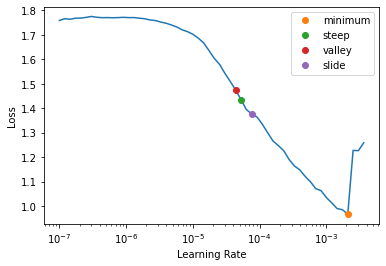

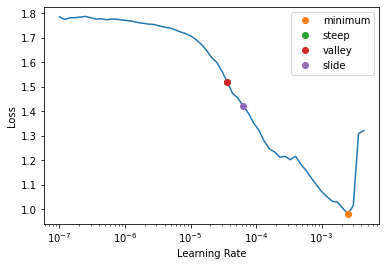

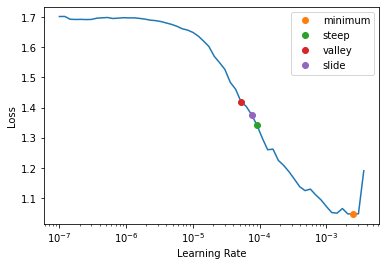

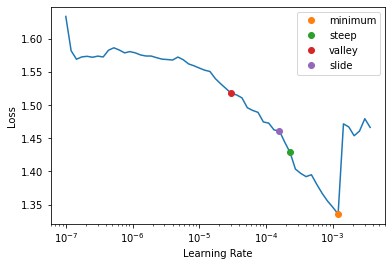

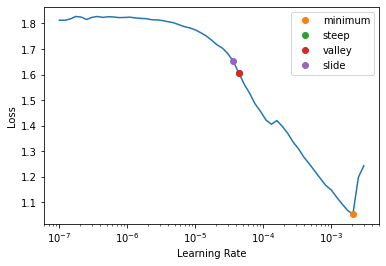

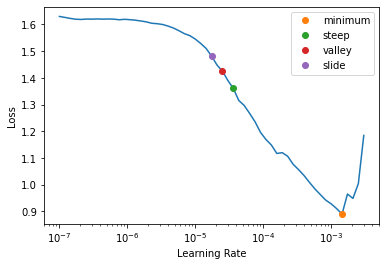

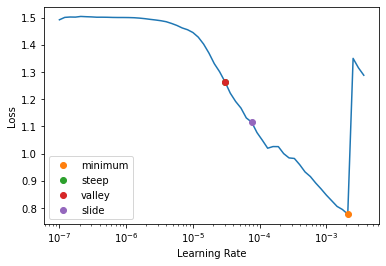

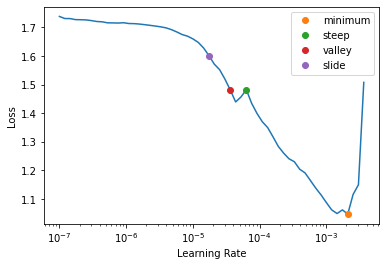

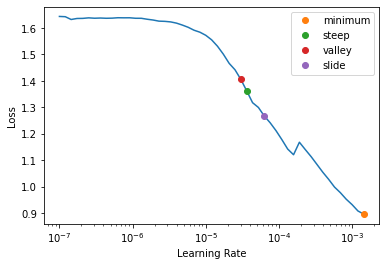

In [32]:
epochs1 = 10
epochs2 = 10

folder_model = 'copper-resnet50-weights'#resnet50 - old rough training data

class CrossEntropyLossFlat(BaseLoss):
    "Same as `nn.CrossEntropyLoss`, but flattens input and target."
    y_int = True
    def __init__(self, *args, axis=-1, **kwargs): super().__init__(nn.CrossEntropyLoss, *args, axis=axis, **kwargs)#
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)
#weights = torch.tensor([[0.1] + [1.9]*4]).cuda()

def get_msk(img_fn):
    str_fn = str(img_fn)
    just_msk_fn = str_fn.split('\\')[-1][:-4] + '_P.png'
    folder = str_fn.rpartition('Segmentation-Copper\\')[0] + label_folder + '/'
    return Path(folder + just_msk_fn)

def FileSplitter(fname):
    "Split `items` depending on the value of `mask`."
    with open(vfn) as f:
        valid = [line.rstrip() for line in f]
    def _func(x): return x.name in valid
    def _inner(o, **kwargs): return FuncSplitter(_func)(o)
    return _inner
    
def create_folder(path_folder):
    import os
    if not os.path.exists(path_folder):
        os.makedirs(path_folder)
    return

def get_weigths_for_val_no(val_no):
    df = pd.read_csv(path + 'copper-weights.csv')
    class_weights = df.loc[df.Split == val_no].values.flatten().tolist()[1:]
    return torch.tensor(class_weights, dtype=torch.float)

#def main():

fnames = get_image_files(path_im)
lbl_names = get_image_files(path_lbl)

#check one image
img_fn = fnames[15]

msk = PILMask.create(get_msk(img_fn))

codes = np.loadtxt(path + 'copper-codes.txt', dtype=str)
bs = 4
sz = msk.shape
half = tuple(int(x/4) for x in sz)
print('sz = ', sz)
print('half = ', half)

names = ['val_no', 'image_size', 'epochs1', 'epochs2', 'minimum', 'steep', 'valley', 'slide', 'valley_loss1', 'valley_acc1', 'valley_loss2', 'valley_acc2', 'running_time']
values = []    
if not os.path.exists(path + 'models/' + folder_model + '/'):
    os.makedirs(path + 'models/' + folder_model + '/')
for val_no in range(3, 12):
    print('Startin val_no:', val_no)
    gc.collect()
    start_time = time.time()
    vfn = path + 'copper-valid.txt'
    print('vfn = ', vfn)
    opera = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                        get_items=get_image_files,
                        splitter=FileSplitter(vfn),
                        get_y=get_msk,
                        batch_tfms=[*aug_transforms(size=half), Normalize.from_stats(*imagenet_stats)])

    dls = opera.dataloaders(path + 'Segmentation-Copper', bs=bs, num_workers = 0)

    dls.vocab = codes

    name2id = {v:k for k,v in enumerate(codes)}

    void_code = name2id['Void']

    def acc_opera(inp, targ):
        targ = targ.squeeze(1)
        #mask = targ != void_code
        return (inp.argmax(dim=1)==targ).float().mean()

    opt = ranger
    learn = unet_learner(dls, resnet50, metrics=acc_opera, self_attention=True, act_cls=Mish, opt_func=opt)
    weights = get_weigths_for_val_no(val_no)
    learn.loss_func = CrossEntropyLossFlat(weight=weights, axis=1)
    print('Finding the lrs.')
    #https://forums.fast.ai/t/new-lr-finder-output/89236/3
    #lrf.valley
    with learn.no_bar():
        lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
    #lrf.valley
    lr = lrs.valley
    print('Start training')
    #with learn.no_bar():
    learn.fit_flat_cos(epochs1, slice(lr))
    print('Validating')
    with learn.no_bar():
        results1 = learn.validate()
    #val_no = 1

    learn.save(path + 'models/' + folder_model + '/' + str(half[0]) + 'x' + str(half[1]) + 'pix_' + str(bs) + 'bs_model-multiple-stage-1-valid' + str(val_no))

    lr2 = slice(lr/400, lr/4)
    learn.unfreeze()

    learn.fit_flat_cos(epochs2, lr2)
    running_time = time.time() - start_time
    with learn.no_bar():
        results2 = learn.validate()
    learn.save(path + 'models/' + folder_model + '/' + str(half[0]) + 'x' + str(half[1]) + 'pix_' + str(bs) + 'bs_model-multiple-stage-2-valid' + str(val_no))
    values.append([val_no, half, epochs1, epochs2, lrs.minimum, lrs.steep, lrs.valley, lrs.slide, results1[0], results1[1], results2[0], results2[1], running_time])
    del acc_opera
    del learn
    del dls
    df = pd.DataFrame(values, columns = names)
    df.to_csv(path + str(bs) + 'bs_res_' + label_folder + folder_model + '.csv', index=False, mode='a', header=not os.path.exists(str(bs) + 'bs_res_' + label_folder + folder_model + '.csv'))

# # Check results - create videos and save csv files

In [46]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from torchvision import transforms
import torchvision.transforms as T
from PIL import ImageFont
from PIL import Image, ImageDraw
from bokeh.palettes import Category20 #to get a color palette
import cv2

import warnings
warnings.filterwarnings("ignore")

np.seterr(invalid='ignore')
def getRGB_from_hex(h):
    h = h[1:] #remove the # from Category20[20][2]    
    h1, h2, h3 = h1, h2, h3 = h[0:2], h[2:4], h[4:6]
    return (int(h1, 16), int(h2, 16), int(h3, 16))

def change_colors (im):
    data = np.array(im)
    red, green, blue = data[:,:,0], data[:,:,1], data[:,:,2]
        
    for i in range(1, 12):
        mask = (red == i) & (green == i) & (blue == i)
        data[:,:,:3][mask] = [colors[i][0], colors[i][1], colors[i][2]]
    return Image.fromarray(data)

def get_validation_files(vfn):
    with open(vfn) as f:
        lines = [line.rstrip() for line in f]
    return lines


def get_msk(img_fn):
    str_fn = str(img_fn)
    just_msk_fn = str_fn.split('\\')[-1][:-4] + '_P.png'
    folder = str_fn.rpartition('Segmentation-Copper\\')[0] + label_folder + '/'
    return Path(folder + just_msk_fn)

def FileSplitter(fname):
    "Split `items` depending on the value of `mask`."
    with open(vfn) as f:
        valid = [line.rstrip() for line in f]
    def _func(x): return x.name in valid
    def _inner(o, **kwargs): return FuncSplitter(_func)(o)
    return _inner

def get_occurrences_pixels_per_class(flatten_list, what_classes):
    existing_for_df = []
    for i in range(len(codes)):
        if i in what_classes:
            existing_for_df.append(list(flatten_list).count(i))
        else:
            existing_for_df.append(0)
    return existing_for_df

def create_folder(path_folder):
    import os
    if not os.path.exists(path_folder):
        os.makedirs(path_folder)
    return

res_img_path = path + 'copper-weights-classified samples/'
create_folder(res_img_path)
folder_model = 'copper-resnet50-weights'

path_im = path + 'Segmentation-Copper'
#res_img_path = path + 'classified samples/'
label_folder = 'Copper-labels'
path_lbl = path + label_folder
vfn = path + 'copper-valid1.txt'

fnames = get_image_files(path_im)
lbl_names = get_image_files(path_lbl)

#check one image
img_fn = fnames[15]

msk = PILMask.create(get_msk(img_fn))

codes = np.loadtxt(path + 'copper-codes.txt', dtype=str)
bs = 4
sz = msk.shape
half = tuple(int(x/4) for x in sz)

stage_no = 2
val_no = 1

# '$Fe$', '$Fe_{2}O_{3}$' '$FeSO_{4}$', '$FeCl_{3}$', '$FeO$'
classes = ['$Cu$', '$CuCl$', '$(CuOH)_{2}C0_3$ ', '$CuO$', '$Cu_2O$']
classes_target = ['target_' + x for x in classes]
predicted_target = ['predicted_' + x for x in classes]
header = ['label_folder', 'model_folder', 'val_no', 'stage_no', 'valid_file'] + classes + ['Overall_acc'] + classes_target + predicted_target

current_model = 'resnet50'

rows_df = []
chosen_trg = []
chosen_pred = []
for val_no in range(1, 12):
    print('Val {} of 11'.format(val_no))
    for stage_no in range(1, 3):#3
        gc.collect()
        #vfn = path + 'validtest.txt'
        vfn = path + 'copper-valid.txt'
        output_path_pixels = res_img_path + 'Pixels/Validation/Val_' + str(val_no)  + '_stage' + str(stage_no) + '/'
        create_folder(output_path_pixels)   
        res = get_validation_files(vfn)
        '''
        current_output_path = path + '/classified samples/validation' + str(val_no)  + '_stage' + str(stage_no) + '/'
        if not os.path.exists(current_output_path):
            os.makedirs(current_output_path)
        '''
        codes = np.loadtxt(path + 'copper-codes.txt', dtype=str)
        sz = msk.shape; sz
        opera = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                            get_items=get_image_files,
                            splitter=FileSplitter(vfn),
                            get_y=get_msk,
                            batch_tfms=[*aug_transforms(size=half), Normalize.from_stats(*imagenet_stats)])
        dls = opera.dataloaders(path + 'Segmentation-Copper\\', bs=8, num_workers = 0)
        
        dls.vocab = codes
        name2id = {v:k for k,v in enumerate(codes)}
        void_code = name2id['Void']
        def acc_opera(inp, targ):
            targ = targ.squeeze(1)
            mask = targ != void_code
            return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()
        opt = ranger
        
        learn = unet_learner(dls, resnet50, metrics=acc_opera, self_attention=True, act_cls=Mish, opt_func=opt)
        
        
        learn.load(path + 'models/' + folder_model + '/' + str(half[0]) + 'x' + str(half[1]) + 'pix_' + str(bs) + 'bs_model-multiple-stage-' + str(stage_no) + '-valid' + str(val_no))
        video_fn = current_model + '_validation' + str(val_no) + '_stage' + str(stage_no) + '_' + folder_model + '_' + label_folder + '.avi'
        print('Starting video', video_fn)
        out = cv2.VideoWriter(res_img_path + video_fn, cv2.VideoWriter_fourcc(*'DIVX'), 15, (971, 386)) # (952, 426))
        
        for valid_file in res:
            current_row = [label_folder, folder_model, val_no, stage_no]
            current_row.append(valid_file)
            fn = path_im + '\\' + valid_file
            test_fn = Path(fn)
        
            msk = PILMask.create(get_msk(test_fn))
            #plt.imshow(msk)
            #plt.savefig(current_output_path + valid_file[:-4] + 'correct.png')
        
            dl = learn.dls.test_dl([test_fn])
            #dl.show_batch(figsize=(8,6))
            img = Image.open(fn)
            #img.show(figsize=(5,5))
            #img.save(current_output_path + valid_file)
            with learn.no_bar():
                preds = learn.get_preds(dl=dl)
            pred_1 = preds[0][0]
            pred_arx = pred_1.argmax(dim=0)
            #plt.imshow(pred_arx)
            #plt.savefig(current_output_path + valid_file[:-4] + 'predicted.png')
            
            #resize the initial label mask to the size of the predicted image
            transform = T.Resize(size = (pred_arx.shape[0], pred_arx.shape[1]), interpolation=Image.NEAREST)
            msk = transform(msk)    
            trg = np.asarray(msk)
            pred_img = np.asarray(pred_arx)
            PIL_image = Image.fromarray(np.uint8(pred_img)).convert('RGB')
            
            matrix = confusion_matrix(trg.flatten(), pred_img.flatten())
            
            separate_acuracies = matrix.diagonal()/matrix.sum(axis=1)
            overall_accuracy = accuracy_score(trg.flatten(), pred_img.flatten())

            data = asarray([trg.flatten(), pred_img.flatten()])
            # save to csv file
            savetxt(output_path_pixels + valid_file[:-3] + 'csv', data, fmt='%i', delimiter=',')

            '''
            #if I want to check a certain file
            if valid_file == 'Cu_0.04__Fe_99.05__P_0.05__Si_0.39__Al_0.03__9 - Cui roman - fier - inainte__2.jpg':
                chosen_trg = trg.flatten()
                chosen_pred = pred_img.flatten()
                print(matrix)
            '''
            existing_classes = np.unique(trg.flatten())
            found_classes = np.unique(pred_img.flatten())
            '''
            i = 0
            for c in existing_classes:
                print(codes[c] + ': ' + str(round(100 * separate_acuracies[i], 2)) + '%')
                i += 1
            print('Overall: ' + str(round(100 * overall_accuracy, 2)) + '%')
            '''
            colors = [(0, 0, 0)]
            for i in range(12):
                colors.append(getRGB_from_hex(Category20[20][i]))
            rgb_msk = Image.new("RGB", msk.size)
            rgb_msk.paste(msk)
            rgb_pred = Image.new("RGB", PIL_image.size)
            rgb_pred.paste(PIL_image)
            
            rgb_pred = change_colors(rgb_pred)
            rgb_msk = change_colors(rgb_msk)
            images = [x for x in [img, rgb_msk, rgb_pred]]
            
            fraction = 0.503
            images[0] = images[0].resize( [int(fraction * s) for s in images[0].size] )
            widths, heights = zip(*(i.size for i in images))
            
            draw = ImageDraw.Draw(images[1])
            # font = ImageFont.truetype(<font-file>, <font-size>)
            font = ImageFont.truetype("./arial.ttf", 25)
            # draw.text((x, y),"Sample Text",(r,g,b))
            draw.text((20, 0),"Expert",(254, 254, 254),font=font)
            
            draw = ImageDraw.Draw(images[2])
            # font = ImageFont.truetype(<font-file>, <font-size>)
            font = ImageFont.truetype("./arial.ttf", 25)
            
            # draw.text((x, y),"Sample Text",(r,g,b))
            draw.text((20, 0),"Model",(254, 254, 254), font=font)
            
            total_width = widths[0] + widths[1]  + 200
            max_height = max(heights)
            
            #create the new image with original, correct, predicted
            new_im = Image.new('RGB', (total_width, max_height))
            
            x_offset = 0
            new_im.paste(images[0], (x_offset,0))
            x_offset += images[0].size[0]
            new_im.paste(images[1], (x_offset,0))
            y_offset = images[1].size[1] + 20
            new_im.paste(images[2], (x_offset + int((widths[1] - widths[2]) / 2), y_offset))
            
            
            x_offset = 0
            new_im.paste(images[0], (x_offset,0))
            x_offset += images[0].size[0]
            new_im.paste(images[1], (x_offset,0))
            y_offset = images[1].size[1]
            new_im.paste(images[2], (x_offset + int((widths[1] - widths[2]) / 2), y_offset))
            #print('Size of the image for video: ', new_im.width, 'x', new_im.height)
            img1 = ImageDraw.Draw(new_im)
            
            #legend
            small_font = ImageFont.truetype("./arial.ttf", 12)
            draw_big = ImageDraw.Draw(new_im)
            
            x = new_im.width - 170
            y = 160
            x_width = 20
            y_width = 10
            j = 0
            img1.rectangle([(x, y - 10), (x + x_width, y  - 10 + y_width)], outline = (127, 127, 127))
            img1.rectangle([(x_offset, 0), (x_offset + images[1].size[0], images[1].size[1])], outline = (127, 127, 127))
            img1.rectangle([(x_offset, images[1].size[1]), (x_offset + images[2].size[0], images[1].size[1] + images[2].size[1])], outline = (127, 127, 127))
            draw_big.text((x + x_width + 5, y - 10), 'Background: ' + str(round(100 * separate_acuracies[0], 2)) + '%', (254, 254, 254), font=small_font)
            current_row.append(round(100 * separate_acuracies[0], 2))
            for i in range(1, len(codes)):
                img1.rectangle([(x, y + 10 * i), (x + x_width, y  + 10 * i + y_width)], fill = Category20[20][i - 1])
                if i in existing_classes:
                    j += 1 # j = 0 is background
                    draw_big.text((x + x_width + 5, y + 10 * i - 1), classes[i] + ': ' + str(round(100 * separate_acuracies[j], 2)) + '%', (254, 254, 254), font=small_font)
                    current_row.append(round(100 * separate_acuracies[j], 2))
                else:
                    if i in found_classes:
                        j += 1
                    draw_big.text((x + x_width + 5, y + 10 * i - 1), classes[i] + ':', (254, 254, 254), font=small_font)
                    current_row.append(0)
                y += 10
            draw_big.text((x + x_width / 2, y + 10 + 10 * (len(codes))), 'Overall: '+ str(round(100 * overall_accuracy, 2)) + '%', (254, 254, 254), font=small_font)
            current_row.append(round(100 * overall_accuracy, 2))
            current_row += get_occurrences_pixels_per_class(trg.flatten(), existing_classes)
            current_row += get_occurrences_pixels_per_class(pred_img.flatten(), found_classes)
            rows_df.append(current_row)
            #frame name
            draw_big.text((20, 20), valid_file, (100, 100, 100), font=small_font)
            
            # Create the video file
            fourcc = cv2.VideoWriter_fourcc(*'DIVX')
            width_video = new_im.width
            height_video = new_im.height
            
            out.write(np.asarray(new_im))
            
        out.release()
df = pd.DataFrame(rows_df, columns = header)

df.to_csv(res_img_path + current_model + '-valid-opera-2stages' + '_' + folder_model + '_' + label_folder + '.csv')

Val 1 of 11
Starting video resnet50_validation1_stage1_copper-resnet50-weights_Copper-labels.avi
Starting video resnet50_validation1_stage2_copper-resnet50-weights_Copper-labels.avi
Val 2 of 11
Starting video resnet50_validation2_stage1_copper-resnet50-weights_Copper-labels.avi
Starting video resnet50_validation2_stage2_copper-resnet50-weights_Copper-labels.avi
Val 3 of 11
Starting video resnet50_validation3_stage1_copper-resnet50-weights_Copper-labels.avi
Starting video resnet50_validation3_stage2_copper-resnet50-weights_Copper-labels.avi
Val 4 of 11
Starting video resnet50_validation4_stage1_copper-resnet50-weights_Copper-labels.avi
Starting video resnet50_validation4_stage2_copper-resnet50-weights_Copper-labels.avi
Val 5 of 11
Starting video resnet50_validation5_stage1_copper-resnet50-weights_Copper-labels.avi
Starting video resnet50_validation5_stage2_copper-resnet50-weights_Copper-labels.avi
Val 6 of 11
Starting video resnet50_validation6_stage1_copper-resnet50-weights_Copper-labe

# Interpret valid csv files

In [6]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt

#select only columns that contain a certain symbol
def get_columns_with_symbol(symbol_name, columns):
    return [x for x in columns if symbol_name in x]

#get all samples where the target of the symbol is > 0
def extract_samples_with_existing_target(symbol_name):
    trg_column =  'target_' + symbol_name
    return df[df[trg_column] > 0], df[df[trg_column] > 0][symbol_name].mean(), df[(df[trg_column] > 0) & (df['stage_no'] == 1)][symbol_name].mean(), df[(df[trg_column] > 0) & (df['stage_no'] == 2)][symbol_name].mean()

def get_acc_for_all_symbols(current_df):
    accuracies = []
    for c in classes:
        accuracies.append(current_df[c].mean())
    return accuracies

def get_df_for_symb_in_interval(low, high, current_df, symbol_name):
    trg_column =  'target_' + symbol_name
    return current_df[(current_df[trg_column] > low) & (current_df[trg_column] < high)]

path_csv = path + 'copper-weights-classified samples/'
plt.style.use('ggplot')
all_csv_files = glob.glob(path_csv + '*.csv')
all_csv_files
df = pd.read_csv(all_csv_files[-1])
df

,Unnamed: 0,label_folder,model_folder,val_no,stage_no,valid_file,$Cu$,$CuCl$,$(CuOH)_{2}C0_3$,$CuO$,...,target_$Cu$,target_$CuCl$,target_$(CuOH)_{2}C0_3$,target_$CuO$,target_$Cu_2O$,predicted_$Cu$,predicted_$CuCl$,predicted_$(CuOH)_{2}C0_3$,predicted_$CuO$,predicted_$Cu_2O$
0,0,Copper-labels,copper-resnet50-weights,1,1,Zn_13.93__Cu_69.16__Fe_1.57__P_0.31__Si_7.81__Al_5.14__51 - Lorica squamata romana - bronz - inainte__6.jpg,64.92,49.20,0.00,95.45,...,47618,376,0,1121,37,31024,675,1664,14077,1712
1,1,Copper-labels,copper-resnet50-weights,1,1,Zn_13.93__Cu_69.16__Fe_1.57__P_0.31__Si_7.81__Al_5.14__51 - Lorica squamata romana - bronz - inainte__7.jpg,70.76,59.73,6.29,92.18,...,47095,365,159,1509,24,33523,717,1810,12116,986
2,2,Copper-labels,copper-resnet50-weights,1,1,Zn_0.88__Cu_50.25__Fe_11.63__Si_4.43__Al_1.31__32 - Buton roman - fier - inainte__1.jpg,85.94,0.00,100.00,87.93,...,47870,0,63,1201,18,41186,23,2296,4382,1265
3,3,Copper-labels,copper-resnet50-weights,1,1,Zn_0.88__Cu_50.25__Fe_11.63__Si_4.43__Al_1.31__32 - Buton roman - fier - inainte__2.jpg,75.56,2.70,0.00,99.36,...,48057,370,0,629,96,36377,278,2249,7738,2510
4,4,Copper-labels,copper-resnet50-weights,1,1,Pb_16.95__Sn_0__Zn_14.12__Cu_57.30__Fe_0.77__141b__10.jpg,54.67,99.06,0.00,32.80,...,45522,318,0,817,2495,25024,12379,12,4834,6903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,457,Copper-labels,copper-resnet50-weights,11,2,Pb_31.97__Sn_21.92__Zn_0.07__Cu_21.28__Fe_6.42__117 - Inel roman - bronz - inainte__4.jpg,99.99,0.00,0.00,0.00,...,49152,0,0,0,0,49148,0,0,4,0
458,458,Copper-labels,copper-resnet50-weights,11,2,Pb_31.97__Sn_21.92__Zn_0.07__Cu_21.28__Fe_6.42__117 - Inel roman - bronz - inainte__5.jpg,100.00,0.00,0.00,0.00,...,49152,0,0,0,0,49152,0,0,0,0
459,459,Copper-labels,copper-resnet50-weights,11,2,Pb_31.97__Sn_21.92__Zn_0.07__Cu_21.28__Fe_6.42__117 - Inel roman - bronz - inainte__6.jpg,100.00,0.00,0.00,0.00,...,49152,0,0,0,0,49152,0,0,0,0
460,460,Copper-labels,copper-resnet50-weights,11,2,Pb_31.97__Sn_21.92__Zn_0.07__Cu_21.28__Fe_6.42__117 - Inel roman - bronz - inainte__7.jpg,100.00,0.00,0.00,0.00,...,49152,0,0,0,0,49152,0,0,0,0


In [7]:
all_csv_files[-1]

'//rcs920/Experiments/2022/OPERA/Segmentation/Copper-train-valid-test/copper-weights-classified samples\\resnet50-valid-opera-2stages_copper-resnet50-weights_Copper-labels.csv'

In [14]:
symbol_name = '$CuCl$'
trg_column =  'target_' + symbol_name
df[(df[trg_column] > 0) & (df['val_no'] == 1)]

,Unnamed: 0,label_folder,model_folder,val_no,stage_no,valid_file,$Cu$,$CuCl$,$(CuOH)_{2}C0_3$,$CuO$,...,target_$Cu$,target_$CuCl$,target_$(CuOH)_{2}C0_3$,target_$CuO$,target_$Cu_2O$,predicted_$Cu$,predicted_$CuCl$,predicted_$(CuOH)_{2}C0_3$,predicted_$CuO$,predicted_$Cu_2O$
0,0,Copper-labels,copper-resnet50-weights,1,1,Zn_13.93__Cu_69.16__Fe_1.57__P_0.31__Si_7.81__Al_5.14__51 - Lorica squamata romana - bronz - inainte__6.jpg,64.92,49.20,0.00,95.45,...,47618,376,0,1121,37,31024,675,1664,14077,1712
1,1,Copper-labels,copper-resnet50-weights,1,1,Zn_13.93__Cu_69.16__Fe_1.57__P_0.31__Si_7.81__Al_5.14__51 - Lorica squamata romana - bronz - inainte__7.jpg,70.76,59.73,6.29,92.18,...,47095,365,159,1509,24,33523,717,1810,12116,986
3,3,Copper-labels,copper-resnet50-weights,1,1,Zn_0.88__Cu_50.25__Fe_11.63__Si_4.43__Al_1.31__32 - Buton roman - fier - inainte__2.jpg,75.56,2.70,0.00,99.36,...,48057,370,0,629,96,36377,278,2249,7738,2510
4,4,Copper-labels,copper-resnet50-weights,1,1,Pb_16.95__Sn_0__Zn_14.12__Cu_57.30__Fe_0.77__141b__10.jpg,54.67,99.06,0.00,32.80,...,45522,318,0,817,2495,25024,12379,12,4834,6903
5,5,Copper-labels,copper-resnet50-weights,1,1,Pb_16.95__Sn_0__Zn_14.12__Cu_57.30__Fe_0.77__141b__2.jpg,79.97,96.69,86.56,0.00,...,46094,121,1674,0,1263,37097,1766,5827,2702,1760
7,7,Copper-labels,copper-resnet50-weights,1,1,Pb_16.95__Sn_0__Zn_14.12__Cu_57.30__Fe_0.77__141b__4.jpg,73.42,99.09,73.30,0.00,...,44435,110,1236,0,3371,33418,3823,7276,2005,2630
8,8,Copper-labels,copper-resnet50-weights,1,1,Pb_16.95__Sn_0__Zn_14.12__Cu_57.30__Fe_0.77__141b__5.jpg,81.76,99.77,35.23,96.43,...,46144,882,826,112,1188,38307,2871,3899,3066,1009
12,12,Copper-labels,copper-resnet50-weights,1,1,Pb_16.95__Sn_0__Zn_14.12__Cu_57.30__Fe_0.77__141b__9.jpg,65.89,29.63,95.58,78.81,...,42817,54,769,3030,2482,28533,97,2010,6736,11776
21,21,Copper-labels,copper-resnet50-weights,1,2,Zn_13.93__Cu_69.16__Fe_1.57__P_0.31__Si_7.81__Al_5.14__51 - Lorica squamata romana - bronz - inainte__6.jpg,70.36,60.37,0.00,90.72,...,47618,376,0,1121,37,33676,1202,2389,9785,2100
22,22,Copper-labels,copper-resnet50-weights,1,2,Zn_13.93__Cu_69.16__Fe_1.57__P_0.31__Si_7.81__Al_5.14__51 - Lorica squamata romana - bronz - inainte__7.jpg,77.16,77.26,10.06,86.35,...,47095,365,159,1509,24,36565,1580,1658,8294,1055


In [17]:
def get_model_name_from_file_path(fn):
    return fn.split('\\')[-1].split('-')[0]

def get_model_type_from_file_path(fn):
    return fn.split('\\')[-1].split('_')[-2]

def get_label_type_from_file_path(fn):
    return fn.split('\\')[-1].split('_')[-1][:-4]

def extract_samples_with_existing_target(symbol_name, val_no):
    trg_column =  'target_' + symbol_name
    return df[(df[trg_column] > 0) & (df['val_no'] == val_no)], df[(df[trg_column] > 0) & (df['val_no'] == val_no)][symbol_name].mean(), df[(df[trg_column] > 0) & (df['stage_no'] == 1) & (df['val_no'] == val_no)][symbol_name].mean(), df[(df[trg_column] > 0) & (df['stage_no'] == 2) & (df['val_no'] == val_no)][symbol_name].mean()


def separate_rows(list_name, add_no):
    separated_lists = [list_name[x:x+8] for x in range(0, len(list_name), 8)]
    return [[add_no] + x for x in separated_lists]

classes = ['$Cu$', '$CuCl$', '$(CuOH)_{2}C0_3$ ', '$CuO$', '$Cu_2O$'] #['$Cu$', 'clorura-$CuCl$', 'hidroxocarbonat - $(CuOH)_{2}C0_3$ ', 'oxid cupric - $CuO$', 'oxid cupros - $Cu_2O$']
classes_target = ['target_' + x for x in classes]
predicted_target = ['predicted_' + x for x in classes]

df = pd.read_csv(all_csv_files[-1])
print(get_model_name_from_file_path(all_csv_files[-1]))
print(all_csv_files[-1])
#acc_overall.append(get_model_name_from_file_path(all_csv_files[i]))
for val_no in range(1, 12):
    acc_overall = []
    acc_stage1 = []
    acc_stage2 = []
    acc_stage1.append(get_label_type_from_file_path(all_csv_files[-1]))
    acc_stage1.append(get_model_type_from_file_path(all_csv_files[-1]))
    acc_stage1.append(val_no)
    acc_stage2.append(get_label_type_from_file_path(all_csv_files[-1]))
    acc_stage2.append(get_model_type_from_file_path(all_csv_files[-1]))
    acc_stage2.append(val_no)
    for current_class_id, c in enumerate(classes):
        symb_should_exist_df, mean_symb_should_exist, mean_stage1_symb_should_exist, mean_stage2_symb_should_exist = extract_samples_with_existing_target(c, val_no)
        #acc_overall.append(mean_symb_should_exist)
        acc_stage1.append(mean_stage1_symb_should_exist)
        acc_stage2.append(mean_stage2_symb_should_exist)
        print('Class {} is {} and its accuracy is: {}, {}, {}'.format(current_class_id, c, mean_symb_should_exist, mean_stage1_symb_should_exist, mean_stage2_symb_should_exist))
    #acc_overall  = separate_rows(acc_overall, 0)
    acc_stage1  = separate_rows(acc_stage1, 1)
    acc_stage2  = separate_rows(acc_stage2, 2)
    print('acc_stage1 = ', acc_stage1)
    print('acc_stage2 = ', acc_stage2)
    if val_no == 1:
        df_separated = pd.DataFrame(acc_stage1, columns = ['stage', 'label_folder', 'model_folder', 'val_no'] + classes)        
    else:
        df_separated = df_separated.append(pd.DataFrame(acc_stage1, columns=df_separated.columns)).reset_index(drop=True)
    df_separated = df_separated.append(pd.DataFrame(acc_stage2, columns=df_separated.columns)).reset_index(drop=True)

df_separated

resnet50
//rcs920/Experiments/2022/OPERA/Segmentation/Copper-train-valid-test/copper-weights-classified samples\resnet50-valid-opera-2stages_copper-resnet50-weights_Copper-labels.csv
Class 0 is $Cu$ and its accuracy is: 81.67690476190477, 79.67333333333332, 83.68047619047618
Class 1 is $CuCl$ and its accuracy is: 66.98, 66.98375, 66.97625000000001
Class 2 is $(CuOH)_{2}C0_3$  and its accuracy is: 66.5575, 64.492, 68.623
Class 3 is $CuO$ and its accuracy is: 76.387, 79.766, 73.00800000000001
Class 4 is $Cu_2O$ and its accuracy is: 67.76692307692306, 71.96461538461539, 63.56923076923078
acc_stage1 =  [[1, 'Copper-labels', 'copper-resnet50-weights', 1, 79.67333333333332, 66.98375, 64.492, 79.766, 71.96461538461539]]
acc_stage2 =  [[2, 'Copper-labels', 'copper-resnet50-weights', 1, 83.68047619047618, 66.97625000000001, 68.623, 73.00800000000001, 63.56923076923078]]
Class 0 is $Cu$ and its accuracy is: 99.38738095238097, 99.45904761904761, 99.3157142857143
Class 1 is $CuCl$ and its accuracy

,stage,label_folder,model_folder,val_no,$Cu$,$CuCl$,$(CuOH)_{2}C0_3$,$CuO$,$Cu_2O$
0,1,Copper-labels,copper-resnet50-weights,1,79.673333,66.98375,64.492,79.766,71.964615
1,2,Copper-labels,copper-resnet50-weights,1,83.680476,66.97625,68.623,73.008,63.569231
2,1,Copper-labels,copper-resnet50-weights,2,99.459048,2.30000,0.016,0.693,13.527692
3,2,Copper-labels,copper-resnet50-weights,2,99.315714,2.95250,0.024,0.844,21.983846
4,1,Copper-labels,copper-resnet50-weights,3,99.656190,0.14125,7.368,8.358,5.173077
5,2,Copper-labels,copper-resnet50-weights,3,99.649524,1.63000,4.796,11.882,6.686923
6,1,Copper-labels,copper-resnet50-weights,4,99.682857,1.68625,0.037,0.000,5.440769
7,2,Copper-labels,copper-resnet50-weights,4,99.440952,5.97750,4.566,0.000,13.170769
8,1,Copper-labels,copper-resnet50-weights,5,99.193810,1.61625,10.822,2.930,16.157692
9,2,Copper-labels,copper-resnet50-weights,5,99.239048,3.38500,10.825,6.987,23.277692


In [20]:
df_separated['segmentation_all_acc'] = df_separated[[classes[0], classes[1], classes[2], classes[3], classes[4]]].mean(axis=1)
df_separated.sort_values(by=['segmentation_all_acc'], ascending=False)

,stage,label_folder,model_folder,val_no,$Cu$,$CuCl$,$(CuOH)_{2}C0_3$,$CuO$,$Cu_2O$,segmentation_all_acc
0,1,Copper-labels,copper-resnet50-weights,1,79.673333,66.98375,64.492,79.766,71.964615,72.575940
1,2,Copper-labels,copper-resnet50-weights,1,83.680476,66.97625,68.623,73.008,63.569231,71.171391
11,2,Copper-labels,copper-resnet50-weights,6,92.745714,25.53750,53.876,44.572,55.959231,54.538089
10,1,Copper-labels,copper-resnet50-weights,6,93.124762,16.31625,49.731,47.913,51.937692,51.804541
19,2,Copper-labels,copper-resnet50-weights,10,98.767619,3.94000,14.179,0.273,33.190000,30.069924
13,2,Copper-labels,copper-resnet50-weights,7,99.210952,14.36625,0.920,19.407,11.578462,29.096533
9,2,Copper-labels,copper-resnet50-weights,5,99.239048,3.38500,10.825,6.987,23.277692,28.742748
18,1,Copper-labels,copper-resnet50-weights,10,99.038095,2.50875,8.808,0.003,28.384615,27.748492
8,1,Copper-labels,copper-resnet50-weights,5,99.193810,1.61625,10.822,2.930,16.157692,26.143950
3,2,Copper-labels,copper-resnet50-weights,2,99.315714,2.95250,0.024,0.844,21.983846,25.024012


# Check test set now

In [4]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from torchvision import transforms
import torchvision.transforms as T
from PIL import ImageFont
from PIL import Image, ImageDraw
from bokeh.palettes import Category20 #to get a color palette
import cv2
from numpy import asarray
from numpy import savetxt
import warnings
warnings.filterwarnings("ignore")

np.seterr(invalid='ignore')
def getRGB_from_hex(h):
    h = h[1:] #remove the # from Category20[20][2]    
    h1, h2, h3 = h1, h2, h3 = h[0:2], h[2:4], h[4:6]
    return (int(h1, 16), int(h2, 16), int(h3, 16))

def change_colors (im):
    data = np.array(im)
    red, green, blue = data[:,:,0], data[:,:,1], data[:,:,2]
        
    for i in range(1, 12):
        mask = (red == i) & (green == i) & (blue == i)
        data[:,:,:3][mask] = [colors[i][0], colors[i][1], colors[i][2]]
    return Image.fromarray(data)

def get_validation_files(vfn):
    with open(vfn) as f:
        lines = [line.rstrip() for line in f]
    return lines


def get_msk(img_fn):
    str_fn = str(img_fn)
    just_msk_fn = str_fn.split('\\')[-1][:-4] + '_P.png'
    folder = str_fn.rpartition('test-segmentation-copper\\')[0] + label_folder + '/'
    return Path(folder + just_msk_fn)

def FileSplitter(fname):
    "Split `items` depending on the value of `mask`."
    with open(vfn) as f:
        valid = [line.rstrip() for line in f]
    def _func(x): return x.name in valid
    def _inner(o, **kwargs): return FuncSplitter(_func)(o)
    return _inner

def get_occurrences_pixels_per_class(flatten_list, what_classes):
    existing_for_df = []
    for i in range(len(codes)):
        if i in what_classes:
            existing_for_df.append(list(flatten_list).count(i))
        else:
            existing_for_df.append(0)
    return existing_for_df

def create_folder(path_folder):
    import os
    if not os.path.exists(path_folder):
        os.makedirs(path_folder)
    return

res_img_path = path + 'copper-weights-classified samples/'
create_folder(res_img_path)
folder_model = 'copper-resnet50-weights'

path_im = path + 'test-segmentation-copper'
#res_img_path = path + 'classified samples/'
label_folder = 'test-segmentation-copper-labels'
path_lbl = path + label_folder
vfn = path + 'copper-test.txt'

fnames = get_image_files(path_im)
lbl_names = get_image_files(path_lbl)

#check one image
img_fn = fnames[15]

msk = PILMask.create(get_msk(img_fn))

codes = np.loadtxt(path + 'copper-codes.txt', dtype=str)
bs = 4
sz = msk.shape
half = tuple(int(x/4) for x in sz)

stage_no = 2
val_no = 1
# '$Fe$', '$Fe_{2}O_{3}$' '$FeSO_{4}$', '$FeCl_{3}$', '$FeO$'
classes = ['$Cu$', '$CuCl$', '$(CuOH)_{2}C0_3$ ', '$CuO$', '$Cu_2O$']
classes_target = ['target_' + x for x in classes]
predicted_target = ['predicted_' + x for x in classes]
header = ['label_folder', 'model_folder', 'val_no', 'stage_no', 'valid_file'] + classes + ['Overall_acc'] + classes_target + predicted_target

current_model = 'resnet50'

rows_df = []
chosen_trg = []
chosen_pred = []
for val_no in range(1, 12):
    print('Test {} out of 11'.format(val_no))
    for stage_no in range(1, 3):#3
        gc.collect()
        #vfn = path + 'validtest.txt'
        vfn = path + 'copper-test.txt'
        
        res = get_validation_files(vfn)
        
        output_path_pixels = res_img_path + 'Pixels/Test/Test_' + str(val_no)  + '_stage' + str(stage_no) + '/'
        create_folder(output_path_pixels)            
        
        codes = np.loadtxt(path + 'copper-codes.txt', dtype=str)
        sz = msk.shape; sz
        opera = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                            get_items=get_image_files,
                            splitter=FileSplitter(vfn),
                            get_y=get_msk,
                            batch_tfms=[*aug_transforms(size=half), Normalize.from_stats(*imagenet_stats)])
        dls = opera.dataloaders(path + 'test-segmentation-copper\\', bs=8, num_workers = 0)
        
        dls.vocab = codes
        name2id = {v:k for k,v in enumerate(codes)}
        void_code = name2id['Void']
        def acc_opera(inp, targ):
            targ = targ.squeeze(1)
            mask = targ != void_code
            return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()
        opt = ranger
        
        learn = unet_learner(dls, resnet50, metrics=acc_opera, self_attention=True, act_cls=Mish, opt_func=opt)
        
        
        learn.load(path + 'models/' + folder_model + '/' + str(half[0]) + 'x' + str(half[1]) + 'pix_' + str(bs) + 'bs_model-multiple-stage-' + str(stage_no) + '-valid' + str(val_no))
        video_fn = current_model + '_test_stage' + str(stage_no) + '_val_no' + str(val_no) + '_' + folder_model + '_' + label_folder + '.avi'
        print('Starting video', video_fn)
        out = cv2.VideoWriter(res_img_path + video_fn, cv2.VideoWriter_fourcc(*'DIVX'), 15, (971, 386)) # (952, 426))
        
        for valid_file in res:
            current_row = [label_folder, folder_model, val_no, stage_no]
            current_row.append(valid_file)
            fn = path_im + '\\' + valid_file
            test_fn = Path(fn)
        
            msk = PILMask.create(get_msk(test_fn))
            #plt.imshow(msk)
            #plt.savefig(current_output_path + valid_file[:-4] + 'correct.png')
        
            dl = learn.dls.test_dl([test_fn])
            #dl.show_batch(figsize=(8,6))
            img = Image.open(fn)
            #img.show(figsize=(5,5))
            #img.save(current_output_path + valid_file)
            with learn.no_bar():
                preds = learn.get_preds(dl=dl)
            pred_1 = preds[0][0]
            pred_arx = pred_1.argmax(dim=0)
            #plt.imshow(pred_arx)
            #plt.savefig(current_output_path + valid_file[:-4] + 'predicted.png')
            
            #resize the initial label mask to the size of the predicted image
            transform = T.Resize(size = (pred_arx.shape[0], pred_arx.shape[1]), interpolation=Image.NEAREST)
            msk = transform(msk)    
            trg = np.asarray(msk)
            pred_img = np.asarray(pred_arx)
            PIL_image = Image.fromarray(np.uint8(pred_img)).convert('RGB')
            
            matrix = confusion_matrix(trg.flatten(), pred_img.flatten())
            
            separate_acuracies = matrix.diagonal()/matrix.sum(axis=1)
            overall_accuracy = accuracy_score(trg.flatten(), pred_img.flatten())
            
            data = asarray([trg.flatten(), pred_img.flatten()])
            # save to csv file
            savetxt(output_path_pixels + valid_file[:-3] + 'csv', data, fmt='%i', delimiter=',')
            
            existing_classes = np.unique(trg.flatten())
            found_classes = np.unique(pred_img.flatten())
            '''
            i = 0
            for c in existing_classes:
                print(codes[c] + ': ' + str(round(100 * separate_acuracies[i], 2)) + '%')
                i += 1
            print('Overall: ' + str(round(100 * overall_accuracy, 2)) + '%')
            '''
            colors = [(0, 0, 0)]
            for i in range(12):
                colors.append(getRGB_from_hex(Category20[20][i]))
            rgb_msk = Image.new("RGB", msk.size)
            rgb_msk.paste(msk)
            rgb_pred = Image.new("RGB", PIL_image.size)
            rgb_pred.paste(PIL_image)
            
            rgb_pred = change_colors(rgb_pred)
            rgb_msk = change_colors(rgb_msk)
            images = [x for x in [img, rgb_msk, rgb_pred]]
            
            fraction = 0.503
            images[0] = images[0].resize( [int(fraction * s) for s in images[0].size] )
            widths, heights = zip(*(i.size for i in images))
            
            draw = ImageDraw.Draw(images[1])
            # font = ImageFont.truetype(<font-file>, <font-size>)
            font = ImageFont.truetype("./arial.ttf", 25)
            # draw.text((x, y),"Sample Text",(r,g,b))
            draw.text((20, 0),"Expert",(254, 254, 254),font=font)
            
            draw = ImageDraw.Draw(images[2])
            # font = ImageFont.truetype(<font-file>, <font-size>)
            font = ImageFont.truetype("./arial.ttf", 25)
            
            # draw.text((x, y),"Sample Text",(r,g,b))
            draw.text((20, 0),"Model",(254, 254, 254), font=font)
            
            total_width = widths[0] + widths[1]  + 200
            max_height = max(heights)
            
            #create the new image with original, correct, predicted
            new_im = Image.new('RGB', (total_width, max_height))
            
            x_offset = 0
            new_im.paste(images[0], (x_offset,0))
            x_offset += images[0].size[0]
            new_im.paste(images[1], (x_offset,0))
            y_offset = images[1].size[1] + 20
            new_im.paste(images[2], (x_offset + int((widths[1] - widths[2]) / 2), y_offset))
            
            
            x_offset = 0
            new_im.paste(images[0], (x_offset,0))
            x_offset += images[0].size[0]
            new_im.paste(images[1], (x_offset,0))
            y_offset = images[1].size[1]
            new_im.paste(images[2], (x_offset + int((widths[1] - widths[2]) / 2), y_offset))
            #print('Size of the image for video: ', new_im.width, 'x', new_im.height)
            img1 = ImageDraw.Draw(new_im)
            
            #legend
            small_font = ImageFont.truetype("./arial.ttf", 12)
            draw_big = ImageDraw.Draw(new_im)
            
            x = new_im.width - 170
            y = 160
            x_width = 20
            y_width = 10
            j = 0
            img1.rectangle([(x, y - 10), (x + x_width, y  - 10 + y_width)], outline = (127, 127, 127))
            img1.rectangle([(x_offset, 0), (x_offset + images[1].size[0], images[1].size[1])], outline = (127, 127, 127))
            img1.rectangle([(x_offset, images[1].size[1]), (x_offset + images[2].size[0], images[1].size[1] + images[2].size[1])], outline = (127, 127, 127))
            draw_big.text((x + x_width + 5, y - 10), 'Background: ' + str(round(100 * separate_acuracies[0], 2)) + '%', (254, 254, 254), font=small_font)
            current_row.append(round(100 * separate_acuracies[0], 2))
            for i in range(1, len(codes)):
                img1.rectangle([(x, y + 10 * i), (x + x_width, y  + 10 * i + y_width)], fill = Category20[20][i - 1])
                if i in existing_classes:
                    j += 1 # j = 0 is background
                    draw_big.text((x + x_width + 5, y + 10 * i - 1), classes[i] + ': ' + str(round(100 * separate_acuracies[j], 2)) + '%', (254, 254, 254), font=small_font)
                    current_row.append(round(100 * separate_acuracies[j], 2))
                else:
                    if i in found_classes:
                        j += 1
                    draw_big.text((x + x_width + 5, y + 10 * i - 1), classes[i] + ':', (254, 254, 254), font=small_font)
                    current_row.append(0)
                y += 10
            draw_big.text((x + x_width / 2, y + 10 + 10 * (len(codes))), 'Overall: '+ str(round(100 * overall_accuracy, 2)) + '%', (254, 254, 254), font=small_font)
            current_row.append(round(100 * overall_accuracy, 2))
            current_row += get_occurrences_pixels_per_class(trg.flatten(), existing_classes)
            current_row += get_occurrences_pixels_per_class(pred_img.flatten(), found_classes)
            rows_df.append(current_row)
            #frame name
            draw_big.text((20, 20), valid_file, (100, 100, 100), font=small_font)
            
            # Create the video file
            fourcc = cv2.VideoWriter_fourcc(*'DIVX')
            width_video = new_im.width
            height_video = new_im.height
            
            out.write(np.asarray(new_im))
            
        out.release()
df = pd.DataFrame(rows_df, columns = header)

df.to_csv(res_img_path + current_model + '-test-opera-2stages' + '_' + folder_model + '_' + label_folder + '.csv')

Val 1 out of 11
Starting video resnet50_test_stage1_val_no1_copper-resnet50-weights_test-segmentation-copper-labels.avi
Starting video resnet50_test_stage2_val_no1_copper-resnet50-weights_test-segmentation-copper-labels.avi
Val 2 out of 11
Starting video resnet50_test_stage1_val_no2_copper-resnet50-weights_test-segmentation-copper-labels.avi
Starting video resnet50_test_stage2_val_no2_copper-resnet50-weights_test-segmentation-copper-labels.avi
Val 3 out of 11
Starting video resnet50_test_stage1_val_no3_copper-resnet50-weights_test-segmentation-copper-labels.avi
Starting video resnet50_test_stage2_val_no3_copper-resnet50-weights_test-segmentation-copper-labels.avi
Val 4 out of 11
Starting video resnet50_test_stage1_val_no4_copper-resnet50-weights_test-segmentation-copper-labels.avi
Starting video resnet50_test_stage2_val_no4_copper-resnet50-weights_test-segmentation-copper-labels.avi
Val 5 out of 11
Starting video resnet50_test_stage1_val_no5_copper-resnet50-weights_test-segmentation-co

In [39]:
from sklearn import metrics
from sklearn.metrics import precision_score
print(metrics.classification_report(trg.flatten(), pred_img.flatten()))
for i in range(len(np.unique(trg.flatten()))):
    print(precision_score(trg.flatten(), pred_img.flatten(), average="binary", pos_label=np.unique(trg.flatten())[i]))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     49001
           3       0.00      0.00      0.00       151

    accuracy                           0.99     49152
   macro avg       0.50      0.50      0.50     49152
weighted avg       0.99      0.99      0.99     49152

0.9969140217857799
0.0


In [43]:
res[0]

'Pb_51.72__Zn_1.50__Cu_22.92__Fe_6.23__110 - Fragment metalic bolt  roman - bronz - inainte__1.jpg'

In [15]:
# save numpy array as csv file
from numpy import asarray
from numpy import savetxt
# define data
data = asarray([trg.flatten(), pred_img.flatten()])
# save to csv file
savetxt('D:/data.csv', data, fmt='%i', delimiter=',')

In [29]:
from numpy import loadtxt
# load array
data = loadtxt('D:/data.csv', delimiter=',')

print(metrics.classification_report(data[0], data[1]))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     49001
         3.0       0.00      0.00      0.00       151

    accuracy                           0.99     49152
   macro avg       0.50      0.50      0.50     49152
weighted avg       0.99      0.99      0.99     49152



# Interpret test csv results

In [28]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt

#select only columns that contain a certain symbol
def get_columns_with_symbol(symbol_name, columns):
    return [x for x in columns if symbol_name in x]

def extract_samples_with_existing_target(symbol_name, val_no):
    trg_column =  'target_' + symbol_name
    return df[(df[trg_column] > 0) & (df['val_no'] == val_no)], df[(df[trg_column] > 0) & (df['val_no'] == val_no)][symbol_name].mean(), df[(df[trg_column] > 0) & (df['stage_no'] == 1) & (df['val_no'] == val_no)][symbol_name].mean(), df[(df[trg_column] > 0) & (df['stage_no'] == 2) & (df['val_no'] == val_no)][symbol_name].mean()

def get_acc_for_all_symbols(current_df):
    accuracies = []
    for c in classes:
        accuracies.append(current_df[c].mean())
    return accuracies

def get_df_for_symb_in_interval(low, high, current_df, symbol_name):
    trg_column =  'target_' + symbol_name
    return current_df[(current_df[trg_column] > low) & (current_df[trg_column] < high)]

path_csv = path + 'copper-weights-classified samples/'
plt.style.use('ggplot')
all_csv_files = glob.glob(path_csv + '*.csv')
all_csv_files
df = pd.read_csv(all_csv_files[0])

def get_model_name_from_file_path(fn):
    return fn.split('\\')[-1].split('-')[0]

def get_model_type_from_file_path(fn):
    return fn.split('\\')[-1].split('_')[-2]

def get_label_type_from_file_path(fn):
    return fn.split('\\')[-1].split('_')[-1][:-4]

def separate_rows(list_name, add_no):
    separated_lists = [list_name[x:x+9] for x in range(0, len(list_name), 9)]
    return [[add_no] + x for x in separated_lists]

df = pd.read_csv(all_csv_files[0])
print(get_model_name_from_file_path(all_csv_files[0]))
print(all_csv_files[0])

for val_no in range(1, 12):
    acc_overall = []
    acc_stage1 = []
    acc_stage2 = []

    #acc_overall.append(get_model_name_from_file_path(all_csv_files[i]))
    acc_stage1.append(get_label_type_from_file_path(all_csv_files[0]))
    acc_stage1.append(get_model_type_from_file_path(all_csv_files[0]))    
    acc_stage1.append(df[df['stage_no'] == 1]['Overall_acc'].mean())
    acc_stage1.append(val_no) 
    acc_stage2.append(get_label_type_from_file_path(all_csv_files[0]))
    acc_stage2.append(get_model_type_from_file_path(all_csv_files[0]))
    acc_stage2.append(df[df['stage_no'] == 2]['Overall_acc'].mean())
    acc_stage2.append(val_no)
    for current_class_id, c in enumerate(classes):
        symb_should_exist_df, mean_symb_should_exist, mean_stage1_symb_should_exist, mean_stage2_symb_should_exist = extract_samples_with_existing_target(c, val_no)
        #acc_overall.append(mean_symb_should_exist)
        acc_stage1.append(mean_stage1_symb_should_exist)
        acc_stage2.append(mean_stage2_symb_should_exist)
        print('Class {} is {} and its accuracy is: {}, {}, {}'.format(current_class_id, c, mean_symb_should_exist, mean_stage1_symb_should_exist, mean_stage2_symb_should_exist))
    #acc_overall  = separate_rows(acc_overall, 0)
    acc_stage1  = separate_rows(acc_stage1, 1)
    acc_stage2  = separate_rows(acc_stage2, 2)
    print('acc_stage1 = ', acc_stage1)
    print('acc_stage2 = ', acc_stage2)

    if val_no == 1:
        df_separated = pd.DataFrame(acc_stage1, columns = ['stage', 'label_folder', 'model_folder', 'overall_pixel_accuracy', 'val_no'] + classes)        
    else:
        df_separated = df_separated.append(pd.DataFrame(acc_stage1, columns=df_separated.columns)).reset_index(drop=True)
    df_separated = df_separated.append(pd.DataFrame(acc_stage2, columns=df_separated.columns)).reset_index(drop=True)

    #df_separated = pd.DataFrame(acc_stage1, columns = ['stage', 'model'] + classes)

df_separated

resnet50
//rcs920/Experiments/2022/OPERA/Segmentation/Copper-train-valid-test/copper-weights-classified samples\resnet50-test-opera-2stages_copper-resnet50-weights_test-segmentation-copper-labels.csv
Class 0 is $Cu$ and its accuracy is: 86.82568181818179, 85.80363636363636, 87.84772727272728
Class 1 is $CuCl$ and its accuracy is: 19.177142857142858, 19.638571428571428, 18.715714285714284
Class 2 is $(CuOH)_{2}C0_3$  and its accuracy is: 59.64888888888889, 65.76888888888888, 53.52888888888889
Class 3 is $CuO$ and its accuracy is: 63.6745238095238, 68.01666666666665, 59.33238095238095
Class 4 is $Cu_2O$ and its accuracy is: 53.486666666666665, 48.95888888888888, 58.01444444444444
acc_stage1 =  [[1, 'test-segmentation-copper-labels', 'copper-resnet50-weights', 96.116694214876, 1, 85.80363636363636, 19.638571428571428, 65.76888888888888, 68.01666666666665, 48.95888888888888]]
acc_stage2 =  [[2, 'test-segmentation-copper-labels', 'copper-resnet50-weights', 96.22037190082642, 1, 87.847727272

,stage,label_folder,model_folder,overall_pixel_accuracy,val_no,$Cu$,$CuCl$,$(CuOH)_{2}C0_3$,$CuO$,$Cu_2O$
0,1,test-segmentation-copper-labels,copper-resnet50-weights,96.116694,1,85.803636,19.638571,65.768889,68.016667,48.958889
1,2,test-segmentation-copper-labels,copper-resnet50-weights,96.220372,1,87.847727,18.715714,53.528889,59.332381,58.014444
2,1,test-segmentation-copper-labels,copper-resnet50-weights,96.116694,2,99.970000,0.908571,0.320000,2.032857,1.615556
3,2,test-segmentation-copper-labels,copper-resnet50-weights,96.220372,2,99.875455,2.354286,1.618889,3.313810,9.113333
4,1,test-segmentation-copper-labels,copper-resnet50-weights,96.116694,3,99.777727,0.770000,9.964444,9.154762,0.394444
5,2,test-segmentation-copper-labels,copper-resnet50-weights,96.220372,3,99.567273,1.225714,9.757778,11.858571,1.225556
6,1,test-segmentation-copper-labels,copper-resnet50-weights,96.116694,4,99.989091,0.090000,0.545556,0.000000,1.725556
7,2,test-segmentation-copper-labels,copper-resnet50-weights,96.220372,4,99.908636,6.615714,3.896667,0.000000,4.781111
8,1,test-segmentation-copper-labels,copper-resnet50-weights,96.116694,5,99.677727,0.210000,19.787778,3.572857,7.465556
9,2,test-segmentation-copper-labels,copper-resnet50-weights,96.220372,5,99.560455,3.022857,20.197778,6.020476,11.692222


In [24]:
path_csv = path + 'copper-weights-classified samples/'
plt.style.use('ggplot')
all_csv_files = glob.glob(path_csv + '*.csv')
all_csv_files

['//rcs920/Experiments/2022/OPERA/Segmentation/Copper-train-valid-test/copper-weights-classified samples\\resnet50-test-opera-2stages_copper-resnet50-weights_test-segmentation-copper-labels.csv',
 '//rcs920/Experiments/2022/OPERA/Segmentation/Copper-train-valid-test/copper-weights-classified samples\\resnet50-valid-opera-2stages_copper-resnet50-weights_Copper-labels.csv']

In [29]:
df_separated['segmentation_all_acc'] = df_separated[[classes[0], classes[1], classes[2], classes[3], classes[4]]].mean(axis=1)
df_separated['segmentation_acc'] = df_separated[[classes[1], classes[2], classes[3], classes[4]]].mean(axis=1)
df_separated.sort_values(by=['segmentation_all_acc'], ascending=False)

,stage,label_folder,model_folder,overall_pixel_accuracy,val_no,$Cu$,$CuCl$,$(CuOH)_{2}C0_3$,$CuO$,$Cu_2O$,segmentation_all_acc,segmentation_acc
0,1,test-segmentation-copper-labels,copper-resnet50-weights,96.116694,1,85.803636,19.638571,65.768889,68.016667,48.958889,57.637330,50.595754
1,2,test-segmentation-copper-labels,copper-resnet50-weights,96.220372,1,87.847727,18.715714,53.528889,59.332381,58.014444,55.487831,47.397857
11,2,test-segmentation-copper-labels,copper-resnet50-weights,96.220372,6,95.617727,14.160000,41.555556,39.160000,45.995556,47.297768,35.217778
10,1,test-segmentation-copper-labels,copper-resnet50-weights,96.116694,6,95.827273,14.971429,50.428889,38.181429,33.674444,46.616693,34.314048
9,2,test-segmentation-copper-labels,copper-resnet50-weights,96.220372,5,99.560455,3.022857,20.197778,6.020476,11.692222,28.098758,10.233333
19,2,test-segmentation-copper-labels,copper-resnet50-weights,96.220372,10,99.502273,3.401429,22.013333,0.740952,13.502222,27.832042,9.914484
8,1,test-segmentation-copper-labels,copper-resnet50-weights,96.116694,5,99.677727,0.210000,19.787778,3.572857,7.465556,26.142784,7.759048
5,2,test-segmentation-copper-labels,copper-resnet50-weights,96.220372,3,99.567273,1.225714,9.757778,11.858571,1.225556,24.726978,6.016905
18,1,test-segmentation-copper-labels,copper-resnet50-weights,96.116694,10,99.821364,0.265714,15.206667,0.006667,7.417778,24.543638,5.724206
13,2,test-segmentation-copper-labels,copper-resnet50-weights,96.220372,7,99.650909,3.617143,4.648889,13.187619,0.650000,24.350912,5.525913


# Create LHS

In [15]:
from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=5, optimization="random-cd")
sample = sampler.random(n=10)

l_bounds = [0, 0, 0, 0, 0]
u_bounds = [10, 10, 10, 10, 10]
a = qmc.scale(sample, l_bounds, u_bounds)
import csv

with open(path + 'lhs.csv', "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(a)

# Run on this data set without any weights

sz =  (768, 1024)
half =  (192, 256)
Startin val_no: 12
vfn =  //rcs920/Experiments/2022/OPERA/Segmentation/Copper-train-valid-test/copper-valid.txt
Finding the lrs.
Start training


epoch,train_loss,valid_loss,acc_opera,time
0,0.730160,0.314410,0.955854,00:15
1,0.462393,0.244622,0.955921,00:15
2,0.364023,0.198945,0.955922,00:15
3,0.304226,0.187634,0.955922,00:15
4,0.273048,0.169874,0.953847,00:15
5,0.255778,0.158155,0.956996,00:15
6,0.234707,0.145550,0.957946,00:15
7,0.216401,0.153247,0.955856,00:15
8,0.202242,0.137354,0.957671,00:15
9,0.190181,0.141955,0.957988,00:15


Validating


epoch,train_loss,valid_loss,acc_opera,time
0,0.177395,0.138404,0.957471,00:16
1,0.172816,0.136908,0.958733,00:15
2,0.172170,0.138052,0.959068,00:15
3,0.172017,0.133285,0.958735,00:15
4,0.169356,0.142145,0.957075,00:16
5,0.171240,0.136801,0.957359,00:15
6,0.166686,0.136308,0.959013,00:15
7,0.167493,0.143289,0.958555,00:15
8,0.161275,0.133536,0.960025,00:15
9,0.157201,0.136656,0.959565,00:15


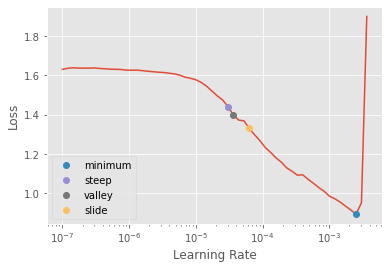

In [32]:
epochs1 = 10
epochs2 = 10

folder_model = 'copper-resnet50-weights'#resnet50 - old rough training data

class CrossEntropyLossFlat(BaseLoss):
    "Same as `nn.CrossEntropyLoss`, but flattens input and target."
    y_int = True
    def __init__(self, *args, axis=-1, **kwargs): super().__init__(nn.CrossEntropyLoss, *args, axis=axis, **kwargs)#
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)
#weights = torch.tensor([[0.1] + [1.9]*4]).cuda()

def get_msk(img_fn):
    str_fn = str(img_fn)
    just_msk_fn = str_fn.split('\\')[-1][:-4] + '_P.png'
    folder = str_fn.rpartition('Segmentation-Copper\\')[0] + label_folder + '/'
    return Path(folder + just_msk_fn)

def FileSplitter(fname):
    "Split `items` depending on the value of `mask`."
    with open(vfn) as f:
        valid = [line.rstrip() for line in f]
    def _func(x): return x.name in valid
    def _inner(o, **kwargs): return FuncSplitter(_func)(o)
    return _inner
    
def create_folder(path_folder):
    import os
    if not os.path.exists(path_folder):
        os.makedirs(path_folder)
    return

def get_weigths_for_val_no(val_no):
    df = pd.read_csv(path + 'copper-weights.csv')
    class_weights = df.loc[df.Split == val_no].values.flatten().tolist()[1:]
    return torch.tensor(class_weights, dtype=torch.float)

#def main():

fnames = get_image_files(path_im)
lbl_names = get_image_files(path_lbl)

#check one image
img_fn = fnames[15]

msk = PILMask.create(get_msk(img_fn))

codes = np.loadtxt(path + 'copper-codes.txt', dtype=str)
bs = 4
sz = msk.shape
half = tuple(int(x/4) for x in sz)
print('sz = ', sz)
print('half = ', half)

names = ['val_no', 'image_size', 'epochs1', 'epochs2', 'minimum', 'steep', 'valley', 'slide', 'valley_loss1', 'valley_acc1', 'valley_loss2', 'valley_acc2', 'running_time']
values = []    
if not os.path.exists(path + 'models/' + folder_model + '/'):
    os.makedirs(path + 'models/' + folder_model + '/')
val_no = 12 #without weights
print('Startin val_no:', val_no)
gc.collect()
start_time = time.time()
vfn = path + 'copper-valid.txt'
print('vfn = ', vfn)
opera = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                    get_items=get_image_files,
                    splitter=FileSplitter(vfn),
                    get_y=get_msk,
                    batch_tfms=[*aug_transforms(size=half), Normalize.from_stats(*imagenet_stats)])

dls = opera.dataloaders(path + 'Segmentation-Copper', bs=bs, num_workers = 0)

dls.vocab = codes

name2id = {v:k for k,v in enumerate(codes)}

void_code = name2id['Void']

def acc_opera(inp, targ):
    targ = targ.squeeze(1)
    #mask = targ != void_code
    return (inp.argmax(dim=1)==targ).float().mean()

opt = ranger
learn = unet_learner(dls, resnet50, metrics=acc_opera, self_attention=True, act_cls=Mish, opt_func=opt)
print('Finding the lrs.')
#https://forums.fast.ai/t/new-lr-finder-output/89236/3
#lrf.valley
with learn.no_bar():
    lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#lrf.valley
lr = lrs.valley
print('Start training')
#with learn.no_bar():
learn.fit_flat_cos(epochs1, slice(lr))
print('Validating')
with learn.no_bar():
    results1 = learn.validate()
#val_no = 1

learn.save(path + 'models/' + folder_model + '/' + str(half[0]) + 'x' + str(half[1]) + 'pix_' + str(bs) + 'bs_model-multiple-stage-1-valid' + str(val_no))

lr2 = slice(lr/400, lr/4)
learn.unfreeze()

learn.fit_flat_cos(epochs2, lr2)
running_time = time.time() - start_time
with learn.no_bar():
    results2 = learn.validate()
learn.save(path + 'models/' + folder_model + '/' + str(half[0]) + 'x' + str(half[1]) + 'pix_' + str(bs) + 'bs_model-multiple-stage-2-valid' + str(val_no))
values.append([val_no, half, epochs1, epochs2, lrs.minimum, lrs.steep, lrs.valley, lrs.slide, results1[0], results1[1], results2[0], results2[1], running_time])
del acc_opera
del learn
del dls
df = pd.DataFrame(values, columns = names)
df.to_csv(path + str(bs) + 'bs_res_' + label_folder + folder_model + '.csv', index=False, mode='a', header=not os.path.exists(str(bs) + 'bs_res_' + label_folder + folder_model + '.csv'))

In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from torchvision import transforms
import torchvision.transforms as T
from PIL import ImageFont
from PIL import Image, ImageDraw
from bokeh.palettes import Category20 #to get a color palette
import cv2

import warnings
warnings.filterwarnings("ignore")

np.seterr(invalid='ignore')
def getRGB_from_hex(h):
    h = h[1:] #remove the # from Category20[20][2]    
    h1, h2, h3 = h1, h2, h3 = h[0:2], h[2:4], h[4:6]
    return (int(h1, 16), int(h2, 16), int(h3, 16))

def change_colors (im):
    data = np.array(im)
    red, green, blue = data[:,:,0], data[:,:,1], data[:,:,2]
        
    for i in range(1, 12):
        mask = (red == i) & (green == i) & (blue == i)
        data[:,:,:3][mask] = [colors[i][0], colors[i][1], colors[i][2]]
    return Image.fromarray(data)

def get_validation_files(vfn):
    with open(vfn) as f:
        lines = [line.rstrip() for line in f]
    return lines


def get_msk(img_fn):
    str_fn = str(img_fn)
    just_msk_fn = str_fn.split('\\')[-1][:-4] + '_P.png'
    folder = str_fn.rpartition('Segmentation-Copper\\')[0] + label_folder + '/'
    return Path(folder + just_msk_fn)

def FileSplitter(fname):
    "Split `items` depending on the value of `mask`."
    with open(vfn) as f:
        valid = [line.rstrip() for line in f]
    def _func(x): return x.name in valid
    def _inner(o, **kwargs): return FuncSplitter(_func)(o)
    return _inner

def get_occurrences_pixels_per_class(flatten_list, what_classes):
    existing_for_df = []
    for i in range(len(codes)):
        if i in what_classes:
            existing_for_df.append(list(flatten_list).count(i))
        else:
            existing_for_df.append(0)
    return existing_for_df

def create_folder(path_folder):
    import os
    if not os.path.exists(path_folder):
        os.makedirs(path_folder)
    return

res_img_path = path + 'copper-weights-classified samples/'
create_folder(res_img_path)
folder_model = 'copper-resnet50-weights'

path_im = path + 'Segmentation-Copper'
#res_img_path = path + 'classified samples/'
label_folder = 'Copper-labels'
path_lbl = path + label_folder
vfn = path + 'copper-valid1.txt'

fnames = get_image_files(path_im)
lbl_names = get_image_files(path_lbl)

#check one image
img_fn = fnames[15]

msk = PILMask.create(get_msk(img_fn))

codes = np.loadtxt(path + 'copper-codes.txt', dtype=str)
bs = 4
sz = msk.shape
half = tuple(int(x/4) for x in sz)

stage_no = 2
val_no = 12

# '$Fe$', '$Fe_{2}O_{3}$' '$FeSO_{4}$', '$FeCl_{3}$', '$FeO$'
classes = ['$Cu$', '$CuCl$', '$(CuOH)_{2}C0_3$ ', '$CuO$', '$Cu_2O$']
classes_target = ['target_' + x for x in classes]
predicted_target = ['predicted_' + x for x in classes]
header = ['label_folder', 'model_folder', 'val_no', 'stage_no', 'valid_file'] + classes + ['Overall_acc'] + classes_target + predicted_target

current_model = 'resnet50'

rows_df = []
chosen_trg = []
chosen_pred = []

for stage_no in range(1, 3):#3
    gc.collect()
    #vfn = path + 'validtest.txt'
    vfn = path + 'copper-valid.txt'
    
    res = get_validation_files(vfn)
    '''
    current_output_path = path + '/classified samples/validation' + str(val_no)  + '_stage' + str(stage_no) + '/'
    if not os.path.exists(current_output_path):
        os.makedirs(current_output_path)
    '''
    codes = np.loadtxt(path + 'copper-codes.txt', dtype=str)
    sz = msk.shape; sz
    opera = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                        get_items=get_image_files,
                        splitter=FileSplitter(vfn),
                        get_y=get_msk,
                        batch_tfms=[*aug_transforms(size=half), Normalize.from_stats(*imagenet_stats)])
    dls = opera.dataloaders(path + 'Segmentation-Copper\\', bs=8, num_workers = 0)
    
    dls.vocab = codes
    name2id = {v:k for k,v in enumerate(codes)}
    void_code = name2id['Void']
    def acc_opera(inp, targ):
        targ = targ.squeeze(1)
        mask = targ != void_code
        return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()
    opt = ranger
    
    learn = unet_learner(dls, resnet50, metrics=acc_opera, self_attention=True, act_cls=Mish, opt_func=opt)
    
    
    learn.load(path + 'models/' + folder_model + '/' + str(half[0]) + 'x' + str(half[1]) + 'pix_' + str(bs) + 'bs_model-multiple-stage-' + str(stage_no) + '-valid' + str(val_no))
    video_fn = current_model + '_validation' + str(val_no) + '_stage' + str(stage_no) + '_' + folder_model + '_' + label_folder + '.avi'
    print('Starting video', video_fn)
    out = cv2.VideoWriter(res_img_path + video_fn, cv2.VideoWriter_fourcc(*'DIVX'), 15, (971, 386)) # (952, 426))
    
    for valid_file in res:
        current_row = [label_folder, folder_model, val_no, stage_no]
        current_row.append(valid_file)
        fn = path_im + '\\' + valid_file
        test_fn = Path(fn)
    
        msk = PILMask.create(get_msk(test_fn))
        #plt.imshow(msk)
        #plt.savefig(current_output_path + valid_file[:-4] + 'correct.png')
    
        dl = learn.dls.test_dl([test_fn])
        #dl.show_batch(figsize=(8,6))
        img = Image.open(fn)
        #img.show(figsize=(5,5))
        #img.save(current_output_path + valid_file)
        with learn.no_bar():
            preds = learn.get_preds(dl=dl)
        pred_1 = preds[0][0]
        pred_arx = pred_1.argmax(dim=0)
        #plt.imshow(pred_arx)
        #plt.savefig(current_output_path + valid_file[:-4] + 'predicted.png')
        
        #resize the initial label mask to the size of the predicted image
        transform = T.Resize(size = (pred_arx.shape[0], pred_arx.shape[1]), interpolation=Image.NEAREST)
        msk = transform(msk)    
        trg = np.asarray(msk)
        pred_img = np.asarray(pred_arx)
        PIL_image = Image.fromarray(np.uint8(pred_img)).convert('RGB')
        
        matrix = confusion_matrix(trg.flatten(), pred_img.flatten())
        
        separate_acuracies = matrix.diagonal()/matrix.sum(axis=1)
        overall_accuracy = accuracy_score(trg.flatten(), pred_img.flatten())
        '''
        #if I want to check a certain file
        if valid_file == 'Cu_0.04__Fe_99.05__P_0.05__Si_0.39__Al_0.03__9 - Cui roman - fier - inainte__2.jpg':
            chosen_trg = trg.flatten()
            chosen_pred = pred_img.flatten()
            print(matrix)
        '''
        existing_classes = np.unique(trg.flatten())
        found_classes = np.unique(pred_img.flatten())
        '''
        i = 0
        for c in existing_classes:
            print(codes[c] + ': ' + str(round(100 * separate_acuracies[i], 2)) + '%')
            i += 1
        print('Overall: ' + str(round(100 * overall_accuracy, 2)) + '%')
        '''
        colors = [(0, 0, 0)]
        for i in range(12):
            colors.append(getRGB_from_hex(Category20[20][i]))
        rgb_msk = Image.new("RGB", msk.size)
        rgb_msk.paste(msk)
        rgb_pred = Image.new("RGB", PIL_image.size)
        rgb_pred.paste(PIL_image)
        
        rgb_pred = change_colors(rgb_pred)
        rgb_msk = change_colors(rgb_msk)
        images = [x for x in [img, rgb_msk, rgb_pred]]
        
        fraction = 0.503
        images[0] = images[0].resize( [int(fraction * s) for s in images[0].size] )
        widths, heights = zip(*(i.size for i in images))
        
        draw = ImageDraw.Draw(images[1])
        # font = ImageFont.truetype(<font-file>, <font-size>)
        font = ImageFont.truetype("./arial.ttf", 25)
        # draw.text((x, y),"Sample Text",(r,g,b))
        draw.text((20, 0),"Expert",(254, 254, 254),font=font)
        
        draw = ImageDraw.Draw(images[2])
        # font = ImageFont.truetype(<font-file>, <font-size>)
        font = ImageFont.truetype("./arial.ttf", 25)
        
        # draw.text((x, y),"Sample Text",(r,g,b))
        draw.text((20, 0),"Model",(254, 254, 254), font=font)
        
        total_width = widths[0] + widths[1]  + 200
        max_height = max(heights)
        
        #create the new image with original, correct, predicted
        new_im = Image.new('RGB', (total_width, max_height))
        
        x_offset = 0
        new_im.paste(images[0], (x_offset,0))
        x_offset += images[0].size[0]
        new_im.paste(images[1], (x_offset,0))
        y_offset = images[1].size[1] + 20
        new_im.paste(images[2], (x_offset + int((widths[1] - widths[2]) / 2), y_offset))
        
        
        x_offset = 0
        new_im.paste(images[0], (x_offset,0))
        x_offset += images[0].size[0]
        new_im.paste(images[1], (x_offset,0))
        y_offset = images[1].size[1]
        new_im.paste(images[2], (x_offset + int((widths[1] - widths[2]) / 2), y_offset))
        #print('Size of the image for video: ', new_im.width, 'x', new_im.height)
        img1 = ImageDraw.Draw(new_im)
        
        #legend
        small_font = ImageFont.truetype("./arial.ttf", 12)
        draw_big = ImageDraw.Draw(new_im)
        
        x = new_im.width - 170
        y = 160
        x_width = 20
        y_width = 10
        j = 0
        img1.rectangle([(x, y - 10), (x + x_width, y  - 10 + y_width)], outline = (127, 127, 127))
        img1.rectangle([(x_offset, 0), (x_offset + images[1].size[0], images[1].size[1])], outline = (127, 127, 127))
        img1.rectangle([(x_offset, images[1].size[1]), (x_offset + images[2].size[0], images[1].size[1] + images[2].size[1])], outline = (127, 127, 127))
        draw_big.text((x + x_width + 5, y - 10), 'Background: ' + str(round(100 * separate_acuracies[0], 2)) + '%', (254, 254, 254), font=small_font)
        current_row.append(round(100 * separate_acuracies[0], 2))
        for i in range(1, len(codes)):
            img1.rectangle([(x, y + 10 * i), (x + x_width, y  + 10 * i + y_width)], fill = Category20[20][i - 1])
            if i in existing_classes:
                j += 1 # j = 0 is background
                draw_big.text((x + x_width + 5, y + 10 * i - 1), classes[i] + ': ' + str(round(100 * separate_acuracies[j], 2)) + '%', (254, 254, 254), font=small_font)
                current_row.append(round(100 * separate_acuracies[j], 2))
            else:
                if i in found_classes:
                    j += 1
                draw_big.text((x + x_width + 5, y + 10 * i - 1), classes[i] + ':', (254, 254, 254), font=small_font)
                current_row.append(0)
            y += 10
        draw_big.text((x + x_width / 2, y + 10 + 10 * (len(codes))), 'Overall: '+ str(round(100 * overall_accuracy, 2)) + '%', (254, 254, 254), font=small_font)
        current_row.append(round(100 * overall_accuracy, 2))
        current_row += get_occurrences_pixels_per_class(trg.flatten(), existing_classes)
        current_row += get_occurrences_pixels_per_class(pred_img.flatten(), found_classes)
        rows_df.append(current_row)
        #frame name
        draw_big.text((20, 20), valid_file, (100, 100, 100), font=small_font)
        
        # Create the video file
        fourcc = cv2.VideoWriter_fourcc(*'DIVX')
        width_video = new_im.width
        height_video = new_im.height
        
        out.write(np.asarray(new_im))
        
    out.release()
df = pd.DataFrame(rows_df, columns = header)

df.to_csv(res_img_path + current_model + '-valid-opera-2stages' + '_' + folder_model + '_' + label_folder + '.csv')

Starting video resnet50_validation12_stage1_copper-resnet50-weights_Copper-labels.avi
Starting video resnet50_validation12_stage2_copper-resnet50-weights_Copper-labels.avi
